# TP n°3 : Arbres de classification

In [94]:
############################################################################
#                Import part
############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import fmod
import seaborn as sns
from sklearn import tree
from sklearn import datasets
import os
import random as rd
from sklearn.model_selection import cross_val_score

In [99]:
%whos

Variable          Type                          Data/Info
---------------------------------------------------------
ListedColormap    type                          <class 'matplotlib.colors.ListedColormap'>
X                 ndarray                       1797x64: 115008 elems, type `float64`, 920064 bytes (898.5 kb)
Xtest             ndarray                       359x64: 22976 elems, type `float64`, 183808 bytes (179.5 kb)
Xtrain            ndarray                       1438x64: 92032 elems, type `float64`, 736256 bytes (719.0 kb)
Y                 ndarray                       1797: 1797 elems, type `int32`, 7188 bytes
Ytest             ndarray                       359: 359 elems, type `int32`, 1436 bytes
Ytrain            ndarray                       1438: 1438 elems, type `int32`, 5752 bytes
cross_val_score   function                      <function cross_val_score at 0x000001C0BB8BFD38>
datasets          module                        <module 'sklearn.datasets<...>\\datasets\\__ini

In [4]:
############################################################################
#                Data Generation
############################################################################


def rand_gauss(n=100, mu=[1, 1], sigma=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigma + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigma1=[0.1, 0.1],
                  sigma2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with std deviation sigma1, sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))]),
                     np.hstack([ex3, 3. * np.ones((n3, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1)
    x2 = np.vstack([sigma2 * np.random.randn(n2),
                    sigma2 * np.random.randn(n2) + 2.])
    res = np.hstack([np.vstack([[x0, x1], 1. * np.ones([1, n1])]),
                     np.vstack([x2, 2. * np.ones([1, n2])])]).T
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_checkers(n1=100, n2=100, n3=100, n4=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nb1 = n1 // 8
    nb2 = n2 // 8
    nb3 = n3 // 8
    nb4 = n4 // 8

    xapp = np.reshape(np.zeros((nb1 + nb2 + nb3 + nb4) * 16),
                      [(nb1 + nb2 + nb3 + nb4) * 8, 2])
    yapp = np.ones((nb1 + nb2 + nb3 + nb4) * 8)
    idx = 0
    nb = 2 * nb1
    for i in range(-2, 2):
        for j in range(-2, 2):
            yapp[idx:(idx + nb)] = [fmod(i - j + 100, 4)] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nb1 + nb2 + nb3 + nb4) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :])


############################################################################
#            Displaying labeled data
############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)


############################################################################
#            Displaying tools for the Frontiere
############################################################################


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

### Question 1 

https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-app-cart.pdf (page 3)

https://fr.wikipedia.org/wiki/Arbre_de_d%C3%A9cision_(apprentissage)#:~:text=Les%20arbres%20de%20r%C3%A9gression%20(Regression,pr%C3%A9diction%20est%20une%20valeur%20num%C3%A9rique.

### Question 2

In [16]:
echantillon = rand_checkers(458, 458, 458, 458)
echantillon[:,0:2]

array([[ 0.99228218, -0.76126915],
       [ 1.89321551, -0.66782155],
       [-0.54977883, -0.75292191],
       ...,
       [-1.36762537, -1.31312836],
       [-0.37035066,  0.73332675],
       [ 0.1187782 ,  0.42973776]])

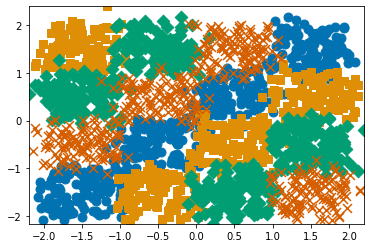

In [15]:
plot_2d(echantillon[:,0:2], echantillon[:,-1])

In [18]:
erreurGini = []
erreurEntropy = []
listInt = [k in range(50)]
for k in range(50):
    modelGini = tree.DecisionTreeClassifier(max_depth=k +1, criterion='gini')
    modelGini.fit(echantillon[:,0:2], echantillon[:,-1])
    modelEntropy = tree.DecisionTreeClassifier(max_depth=k+1, criterion='entropy')
    modelEntropy.fit(echantillon[:,0:2], echantillon[:,-1])
    erreurGini.append(modelGini.score(echantillon[:,0:2], echantillon[:,-1]))
    erreurEntropy.append(modelEntropy.score(echantillon[:,0:2], echantillon[:,-1]))



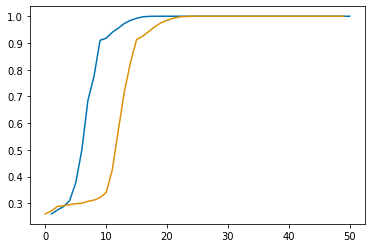

In [33]:
listInt = [k + 1 for k in range(50)]

plt.plot(listInt, erreurGini, erreurEntropy)

### Question 3

In [34]:
X = echantillon[:,0:2]
y = echantillon[:,-1]

modelGini = tree.DecisionTreeClassifier(max_depth=15, criterion='gini')
modelGini.fit(X, y)
modelEntropy = tree.DecisionTreeClassifier(max_depth=20, criterion='entropy')
modelEntropy.fit(X, y)

yGini = modelGini.predict(X)
yEntropy = modelEntropy.predict(X)

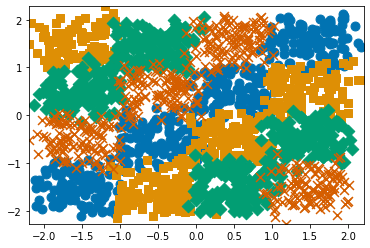

In [36]:
plot_2d(X, yGini)

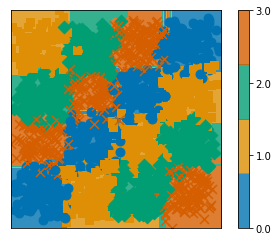

In [47]:
def predict_2(X):
    return modelGini.predict(X.reshape(1,-1))


frontiere_new(predict_2, X, y)

### Question 4

In [54]:
tree.export_graphviz(modelGini, out_file = "Tree.dot", filled = True)

In [53]:
os.system("dot - Tpdf Tree.dot -0 Tree.pdf")

1

### Question 5 

In [56]:
echantillonTest = rand_checkers(160, 160, 160, 160)
Xtest = echantillonTest[:,0:2]
yTest = echantillonTest[:,-1]

In [58]:
modelGini.score(Xtest, yTest)

0.8265625

### Question 6

In [61]:
digits = datasets.load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

In [65]:
digits['data'].shape

(1797, 64)

In [68]:
xtrain = []
while(len(xtrain) < 1438):
    rand = rd.randrange(1797)
    if not(rand in xtrain):
        xtrain.append(rand)
xother = [i for i in range(1797) if not(i in xtrain)]

Xtrain = digits['data'][xtrain]
Xtest = digits['data'][xother]

Ytrain = digits['target'][xtrain]
Ytest = digits['target'][xother]

In [69]:
erreurGini = []
erreurEntropy = []
listInt = [k in range(30)]
for k in range(30):
    modelGini = tree.DecisionTreeClassifier(max_depth=k +1, criterion='gini')
    modelGini.fit(Xtrain, Ytrain)
    modelEntropy = tree.DecisionTreeClassifier(max_depth=k+1, criterion='entropy')
    modelEntropy.fit(Xtrain, Ytrain)
    erreurGini.append(modelGini.score(Xtest, Ytest))
    erreurEntropy.append(modelEntropy.score(Xtest, Ytest))

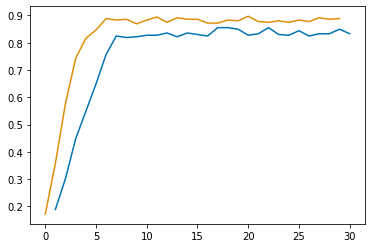

In [73]:
listInt = [k + 1 for k in range(30)]

plt.plot(listInt, erreurGini, erreurEntropy)
plt.show()

In [74]:
modelGini = tree.DecisionTreeClassifier(max_depth=8, criterion='gini')
modelGini.fit(Xtrain, Ytrain)
modelEntropy = tree.DecisionTreeClassifier(max_depth=6, criterion='entropy')
modelEntropy.fit(Xtrain, Ytrain)

yGini = modelGini.predict(Xtest)
yEntropy = modelEntropy.predict(Xtest)

In [81]:
Xtest.dtype

dtype('float64')

In [82]:
yGini.dtype

dtype('int32')

## Méthodes de choix de paramètres - Sélection de modèle

### Question 7 

In [87]:
X = digits['data']
Y = digits['target']

modelGini = tree.DecisionTreeClassifier(max_depth=10, criterion='gini')

modelEntropy = tree.DecisionTreeClassifier(max_depth=10, criterion='entropy')

In [98]:
cross_val_score(modelGini, X, Y, cv = 5)

array([0.78021978, 0.72375691, 0.78830084, 0.82352941, 0.8028169 ])

### Question 8

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    if ylim is not None:
        axes[0].set_ylim(*ylim)

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plt


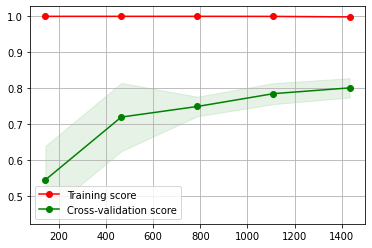

In [119]:
g = plot_learning_curve(modelEntropy, "apprentissage", X, Y, cv = 5)